# Summary of HRC proxy issues related to the GOES source change

Prior to 2020, we were using P4, P5, P6 GOES channels to derive the HRC proxy as follows:
    
__HRC_PROXY__ = 6000 x __P4__ + 270000 x __P5__ + 100000 x __P6__

__P4__ = Protons from 15 - 40 MeV in units of #/cm2-s-sr-MeV<br>
__P5__ = Protons from 38 - 82 MeV in units of #/cm2-s-sr-MeV<br>
__P6__ = Protons from 84 - 200 MeV in units of #/cm2-s-sr-MeV<br>


At this time, the primary GOES source is __GOES-16__ (GOES-R). The SEISS SGPS instrument onboard G16 has energy channels that differ form those of pre-GOES-16 sattelites. GOES-16 data format changed as well, data are now served in the form of json files. 


This notebook covers the following issues:
 1. Drop of the rates in July 2019 when the source changed from GOES-15 to GOES-14
 2. Comparison of proton rates for GOES-14 and GOES-15 proton rates (energy band of protons that dominate the HRC proxy). Factor of 15-16 drop in GOES-14 P5 rates compared to GOES-15 P5 rates.
 3. Comparison of proton rates for GOES-14/15 P5 proton rates and GOES-16 P7 proton rates (energy band for which the proton rates dominate the HRC proxy). Factor of 10 drop in GOES-16 P7 rates compared to GOES-15 P5 rates.
 4. Factor ~2-3 drop between GOES-13/15 P5 proton rates and GOES-16 P7 proton rates (energy band for which the proton rates dominate the HRC proxy) in the high proton rates regime (2017 flare) 
 5. Possible explanation of the drop in rates in terms of a higher sensitivity of the new instrument. However, the scaling appears to depend on the proton rate, and a correlation between the HRC shield rate and GOES proton rates has been observed over several years.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from Ska.engarchive import fetch as fetch
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from ftplib import FTP
from astropy.io import ascii
import json
import requests

In [2]:
NAMES = ['YR', 'MO', 'DA', 'HHMM', 'Day1', 'Day2', 'P1', 'P2', 'P3',
         'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11']

In [3]:
URL = 'https://services.swpc.noaa.gov/json/goes/primary/'

In [4]:
def get_goes_data_1d_json():
    json_file = requests.get(f'{URL}/differential-protons-1-day.json')
    data = json_file.json()
    t = Table(data)
    
    # Extract the lower and upper energy boundaries for each channel
    # by manipulating the ``energy`` column and add ``e_lo`` and
    # ``e_hi`` columns to the table
    elos = []
    ehis = []
    for row in t['energy']:
        tmp = row.split(' ')
        items = tmp[0].split('-')
        elos.append(float(items[0]))
        ehis.append(float(items[1]))
        
    t['e_lo'] = elos
    t['e_hi'] = ehis
    
    return t

def add_date_column(tab):
    hhmm = [f"{t['HHMM']:04d}" for t in tab]
    dates = []
    for row in tab:
        hhmm = f"{row['HHMM']:04d}"
        date = f"{row['YR']}-{row['MO']:02d}-{row['DA']:02d}T{hhmm[:2]}:{hhmm[2:]}:00.000"
        dates.append(date)        
    tab['date'] = dates

def plot_goes_source(tab, color, label):
    plt.figure(figsize=(12, 6))
    plot_cxctime(times, tab['satellite'], color=color, lw=3)
    plt.yticks([13, 14, 15], ["13", "14", "15"])
    plt.xlabel("Time (years)")
    plt.ylabel("GOES #")
    plt.text(DateTime('2016:050:00:00:00').plotdate, 14.5, label,
             fontsize='20', color=color)
    plt.grid()

def compare_g13_14_15_proton_rates(times, t_primary, t_secondary, channel):
    fig = plt.figure(figsize=(12, 6))
    
    okp13 = t_primary['satellite'] == 13
    oks13 = t_secondary['satellite'] == 13
    
    okp14 = t_primary['satellite'] == 14
    oks14 = t_secondary['satellite'] == 14
    
    okp15 = t_primary['satellite'] == 15
    oks15 = t_secondary['satellite'] == 15
    
    colname = f"median_{channel}"
    
    # GOES 13
    plot_cxctime(times[okp13], t_primary[colname][okp13], color='moccasin',
                 marker='o', ms='2', linestyle='None', label='G13 primary')
    plot_cxctime(times[oks13], t_secondary[colname][oks13], color='yellow',
                 marker='o', ms='2', linestyle='None', label='G13 secondary')
    # GOES 14
    plot_cxctime(times[okp14], t_primary[colname][okp14], color='indianred',
                 marker='o', ms='2', linestyle='None', label='G14 primary')
    plot_cxctime(times[oks14], t_secondary[colname][oks14], color='salmon',
                 marker='o', ms='2', linestyle='None', label='G14 secondary')
    # GOES 15
    plot_cxctime(times[okp15], t_primary[colname][okp15], color='C0',
                 marker='o', ms='2', linestyle='None', label='G15 primary')
    plot_cxctime(times[oks15], t_secondary[colname][oks15], color='lightblue',
                 marker='o', ms='2', linestyle='None', label='G15 secondary')
    plt.yscale('log')
    plt.legend()
    plt.ylabel('Protons / cm2-s-sr-MeV')

    ax = fig.axes[0]
    plt.text(0.2, 0.7, channel,
             transform=ax.transAxes, fontsize=30, color='k');
    plt.grid()
    
    
def plot_hrc_shield(times, vals, color='C0', marker=None, linestyle='solid', scale='log'):
    secs = times
    hrc_shield = vals
    bad = hrc_shield < 0.1
    hrc_shield = hrc_shield[~bad]
    secs = secs[~bad]

    plt.figure(1, figsize=(6, 4))
    ticks, fig, ax = plot_cxctime(secs, hrc_shield,
                                  color=color, marker=marker, linestyle=linestyle)
    xlims = ax.get_xlim()
    dx = (xlims[1] - xlims[0]) / 20.
    ax.set_yscale(scale)
    plt.grid()
    plt.ylabel('Cts / sample')
    plt.tight_layout()    

In [5]:
# Uncomment this cell to generate the data table
"""
date1 = '2015-05-30T00:00:00.00'
date2 = '2020-01-23T00:00:00.00'

ftp = FTP("ftp.swpc.noaa.gov")
ftp.login()

ftp.cwd("/pub/lists/pchan/")

rows = []

mjd = DateTime(date1).mjd
while mjd < DateTime(date2).mjd:
    date = DateTime(mjd, format='mjd').fits
    tmp = date.replace("-", "")[:8]
    # secondary data, change to `Gp` for primary data
    filename = f"{tmp}_Gs_pchan_5m.txt"   
    local_filename = "tmp_protons.txt"
    
    # retrieve the file
    lf = open(local_filename, "wb")
    ftp.retrbinary("RETR " + filename, lf.write, 8*1024)
    lf.close()
    
    with open(local_filename) as lf:
        for line in lf:
            if 'Source' in line:
                satellite = line.strip()[-2:]
                row = {'satellite': satellite, 'time_mjd': mjd}
                break

    dat = ascii.read(local_filename, data_start=2)
    
    dat = Table(dat, names=NAMES)
    
    row.update({'median_p4': np.median(dat['P4']),
                'median_p5': np.median(dat['P5']),
                'median_p6': np.median(dat['P6'])})
    
    rows.append(row)

    mjd = mjd + 1

ftp.close()

t = Table(rows)

t.write('goes-secondary-2015-05-30-2020-01-22.dat', format='ascii')
""";

In [6]:
# GOES primary data between 2015-05-30 and 2020-01-22, daily medians for P4, P5, P6
t_primary = Table.read('goes-2015-05-30-2020-01-22.dat', format='ascii')

# GOES secondary data between 2015-05-30 and 2020-01-22, daily medians for P4, P5, P6
t_secondary = Table.read('goes-secondary-2015-05-30-2020-01-22.dat', format='ascii')

In [7]:
t_primary.colnames

['median_p4', 'median_p5', 'median_p6', 'satellite', 'time_mjd']

In [8]:
times = DateTime(t_primary['time_mjd'], format='mjd').secs

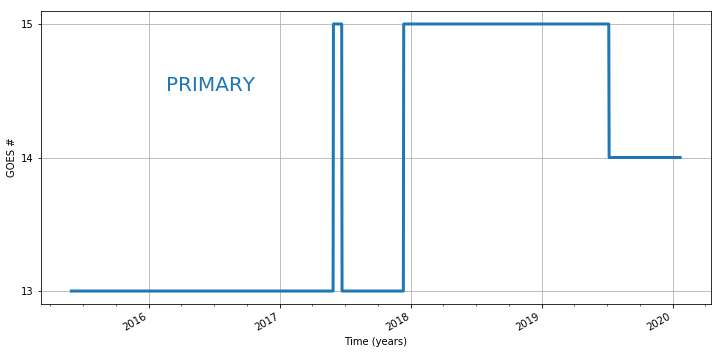

In [9]:
plot_goes_source(t_primary, 'C0', 'PRIMARY')

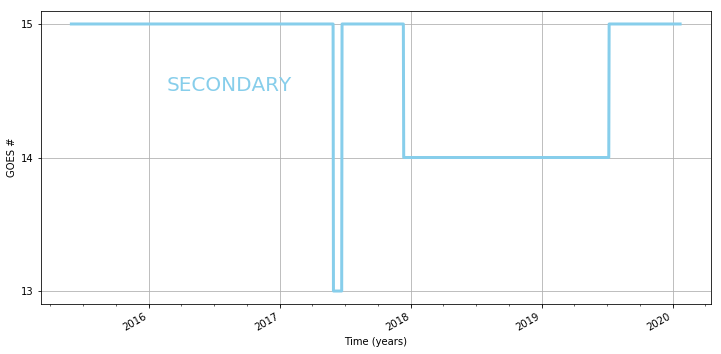

In [10]:
plot_goes_source(t_secondary, 'skyblue', 'SECONDARY')

## Proton rates in GOES-13/14/15

In [11]:
okp13 = t_primary['satellite'] == 13
oks13 = t_secondary['satellite'] == 13

In [12]:
okp14 = t_primary['satellite'] == 14
oks14 = t_secondary['satellite'] == 14

In [13]:
okp15 = t_primary['satellite'] == 15
oks15 = t_secondary['satellite'] == 15

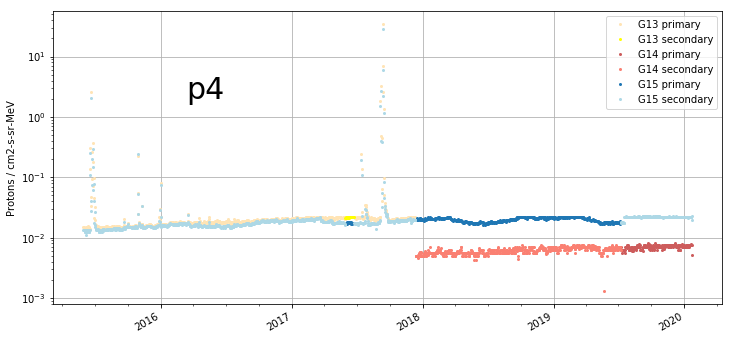

In [14]:
compare_g13_14_15_proton_rates(times, t_primary, t_secondary, 'p4')

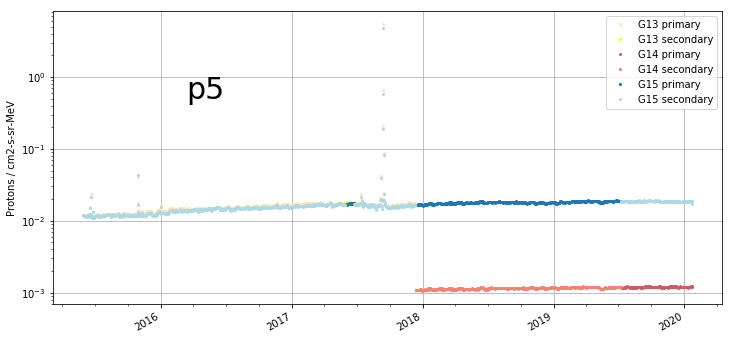

In [15]:
compare_g13_14_15_proton_rates(times, t_primary, t_secondary, 'p5')

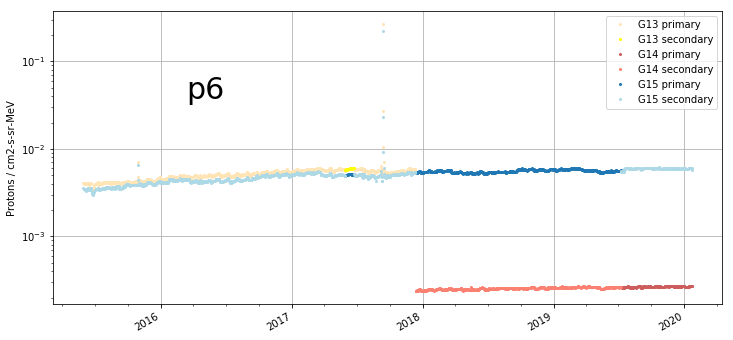

In [16]:
compare_g13_14_15_proton_rates(times, t_primary, t_secondary, 'p6')

__Figure:__ In July 2019, GOES-14 (red) became the primary GOES source. At the same time, a drop in HRC proxy was observed. This drop was identified as due to a drop in P4, P5, P6 proton rates in G14 compared to G15 (blue). Proton rates reported by GOES-13 (yellow) and GOES-15 (blue) were consistent with each other.

## GOES-16 (GOES-R) proton rates

In [17]:
t = get_goes_data_1d_json()

In [18]:
t_tmp = t[:13]
t_tmp.sort('e_lo')
t_tmp

channel,energy,flux,satellite,time_tag,yaw_flip,e_lo,e_hi
str3,str17,float64,int64,str20,int64,float64,float64
P1,1020-1860 keV,7.22199547454e-05,16,2020-04-14T05:25:00Z,0,1020.0,1860.0
P2A,1900-2300 keV,0.0,16,2020-04-14T05:25:00Z,0,1900.0,2300.0
P2B,2310-3340 keV,2.9446588087e-05,16,2020-04-14T05:25:00Z,0,2310.0,3340.0
P3,3400-6480 keV,0.0,16,2020-04-14T05:25:00Z,0,3400.0,6480.0
P4,5840-11000 keV,2.35136849369e-05,16,2020-04-14T05:25:00Z,0,5840.0,11000.0
P5,11640-23270 keV,9.56316762313e-06,16,2020-04-14T05:25:00Z,0,11640.0,23270.0
P6,25900-38100 keV,5.2612796253e-07,16,2020-04-14T05:25:00Z,0,25900.0,38100.0
P7,40300-73400 keV,2.51774667959e-06,16,2020-04-14T05:25:00Z,0,40300.0,73400.0
P8A,83700-98500 keV,7.11288407729e-07,16,2020-04-14T05:25:00Z,0,83700.0,98500.0


__Table:__ GOES-16 has 13 energy channels. FLux is given in 'per keV' units (not 'per MeV' as before).

__Pre-GOES-16 P4__ channel (15-40 MeV) corresponds to a combination of __GOES-16 P5 and P6__ channels (12-38 MeV).<br>
__Pre-GOES-16 P5__ channel (38-82 MeV) corresponds to __GOES-16 P7__ channel (40-73 MeV).<br>
__Pre-GOES-16 P6__ channel (84-200 MeV) corresponds to a combination of __GOES-16 P8A, P8B, P8C and P9__ channels (84-242 MeV).<br>

In [19]:
def filter_channel(channel):
    ok = t['channel'] == channel
    t_tmp = t[ok]
    t_tmp.rename_column('flux', f'{channel}_flux')
    return t_tmp

In [20]:
tabs = []
channels = ['P5', 'P6', 'P7', 'P8A', 'P8B', 'P8C', 'P9']

for channel in channels:
    t_chan = filter_channel(channel)
    tabs.append(t_chan)

In [21]:
tab_all = tabs[0]['time_tag', 'P5_flux']

In [22]:
for ii, channel in enumerate(channels):
    colname = f'{channel}_flux'
    tab_all[colname] = tabs[ii][colname]

In [23]:
time_tags_fits = []
for row in tab_all:
    time_tags_fits.append(row['time_tag'][:-1])
tab_all['time_tag_fits'] = time_tags_fits

In [24]:
tab_all.colnames

['time_tag',
 'P5_flux',
 'P6_flux',
 'P7_flux',
 'P8A_flux',
 'P8B_flux',
 'P8C_flux',
 'P9_flux',
 'time_tag_fits']

In [25]:
de = {'p5': 23270. - 11640.,
      'p6': 38100. - 25900.,
      'p7': 73400. - 40300.,
      'p8a': 98500. - 83700.,
      'p8b': 118000. - 99900.,
      'p8c': 143000. - 115000.,
      'p9': 242000. - 160000.,
      'p5p6': 23270. - 11640.,
      'p8abcp9': 242000. - 83700.}

p5p6_fluxes = []
p8abcp9_fluxes = []

for row in tab_all:
    p5p6_flux = (row['P5_flux'] * de['p5'] + row['P6_flux'] * de['p6']) / de['p5p6']
    p8abcp9_flux = (row['P8A_flux'] * de['p8a'] +
                    row['P8B_flux'] * de['p8b'] +
                    row['P8C_flux'] * de['p8c'] +
                    row['P9_flux'] * de['p9']) / de['p8abcp9']    
    p5p6_fluxes.append(p5p6_flux)
    p8abcp9_fluxes.append(p8abcp9_flux)
    
tab_all['P5P6_flux'] = p5p6_fluxes
tab_all['P8ABCP9_flux'] = p8abcp9_fluxes

In [26]:
tab_all.colnames

['time_tag',
 'P5_flux',
 'P6_flux',
 'P7_flux',
 'P8A_flux',
 'P8B_flux',
 'P8C_flux',
 'P9_flux',
 'time_tag_fits',
 'P5P6_flux',
 'P8ABCP9_flux']

In [27]:
t_primary.colnames

['median_p4', 'median_p5', 'median_p6', 'satellite', 'time_mjd']

In [28]:
t1 = DateTime('2019:180:00:00:00').plotdate
t2 = DateTime('2020:022:00:00:00').plotdate

In [29]:
times14 = DateTime(t_primary['time_mjd'], format='mjd').secs
times15 = DateTime(t_secondary['time_mjd'], format='mjd').secs
times16 = DateTime(tab_all['time_tag_fits'], format='fits').secs

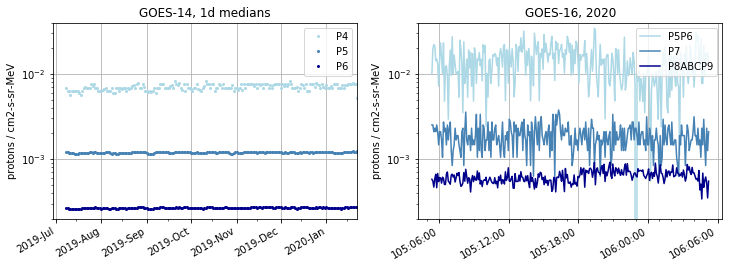

In [30]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_cxctime(times14[okp14], t_primary['median_p4'][okp14], color='lightblue',
             marker='o', ms='2', linestyle='None', label='P4')
plot_cxctime(times14[okp14], t_primary['median_p5'][okp14], color='steelblue',
             marker='o', ms='2', linestyle='None', label='P5')
plot_cxctime(times14[okp14], t_primary['median_p6'][okp14], color='darkblue',
             marker='o', ms='2', linestyle='None', label='P6')
plt.legend()
plt.ylabel('protons / cm2-s-sr-MeV')
plt.title('GOES-14, 1d medians')
plt.yscale('log')
plt.ylim(2e-4, 4e-2)
plt.xlim(t1, t2)
plt.grid()

plt.subplot(1, 2, 2)
plot_cxctime(times16, tab_all['P5P6_flux'] * 1000, 'lightblue', label='P5P6')
plot_cxctime(times16, tab_all['P7_flux'] * 1000, 'steelblue', label='P7')
plot_cxctime(times16, tab_all['P8ABCP9_flux'] * 1000, 'darkblue', label='P8ABCP9')
plt.legend()
plt.ylabel('protons / cm2-s-sr-MeV')
plt.title('GOES-16, 2020')
plt.yscale('log')
plt.ylim(2e-4, 4e-2)
plt.grid()

__Figure:__ Left: 1-day medians of GOES-14 proton rates (primary source prior to GOES-16). Right: GOES-16 proton rates of day 2020:106. It appears there is a factor 2-3 difference between the GOES-14 and GOES-16 rates for the energies that dominate the HRC proxy (P5 and P7, respectively; medium blue).

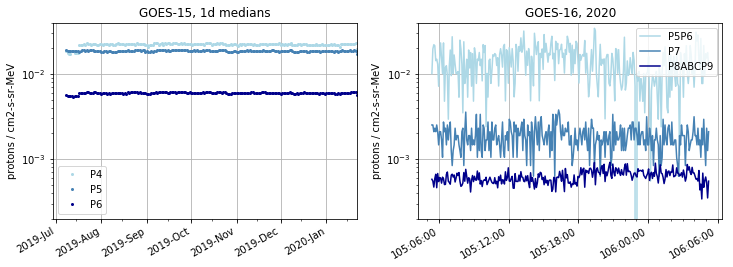

In [31]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_cxctime(times15[oks15], t_secondary['median_p4'][oks15], color='lightblue',
             marker='o', ms='2', linestyle='None', label='P4')
plot_cxctime(times15[oks15], t_secondary['median_p5'][oks15], color='steelblue',
             marker='o', ms='2', linestyle='None', label='P5')
plot_cxctime(times15[oks15], t_secondary['median_p6'][oks15], color='darkblue',
             marker='o', ms='2', linestyle='None', label='P6')
plt.legend()
plt.ylabel('protons / cm2-s-sr-MeV')
plt.title('GOES-15, 1d medians')
plt.yscale('log')
plt.ylim(2e-4, 4e-2)
plt.xlim(t1, t2)
plt.grid()

plt.subplot(1, 2, 2)
plot_cxctime(times16, tab_all['P5P6_flux'] * 1000, 'lightblue', label='P5P6')
plot_cxctime(times16, tab_all['P7_flux'] * 1000, 'steelblue', label='P7')
plot_cxctime(times16, tab_all['P8ABCP9_flux'] * 1000, 'darkblue', label='P8ABCP9')
plt.legend()
plt.ylabel('protons / cm2-s-sr-MeV')
plt.title('GOES-16, 2020')
plt.yscale('log')
plt.ylim(2e-4, 4e-2)
plt.grid()

__Figure:__ In the quiet period, it appears that G14 proton rates (red) in P5 channel (38 - 82 MeV #/cm2-s-sr-MeV) need to be scaled by a factor of ~15-16 to match G15 proton rates (blue).

## Comparison of P5 GOES-14/15 and P7 GOES-16 proton rates

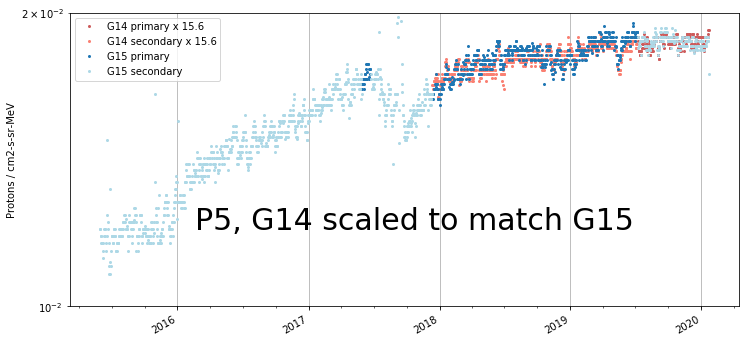

In [32]:
factor = 15.6

plt.figure(figsize=(12, 6))
# GOES 14
plot_cxctime(times[okp14], t_primary['median_p5'][okp14] * factor,
             color='indianred', marker='o', ms='2', linestyle='None', label=f'G14 primary x {factor}')
plot_cxctime(times[oks14], t_secondary['median_p5'][oks14] * factor,
             color='salmon', marker='o', ms='2', linestyle='None', label=f'G14 secondary x {factor}')
# GOES 15
plot_cxctime(times[okp15], t_primary['median_p5'][okp15], color='C0',
             marker='o', ms='2', linestyle='None', label='G15 primary')
plot_cxctime(times[oks15], t_secondary['median_p5'][oks15], color='lightblue',
             marker='o', ms='2', linestyle='None', label='G15 secondary')
plt.yscale('log')
plt.legend()
plt.ylabel('Protons / cm2-s-sr-MeV')
plt.text(DateTime('2016:050:00:00:00').plotdate, 0.012,
         'P5, G14 scaled to match G15', fontsize=30, color='k')
plt.ylim(1e-2, 2e-2)
plt.grid()

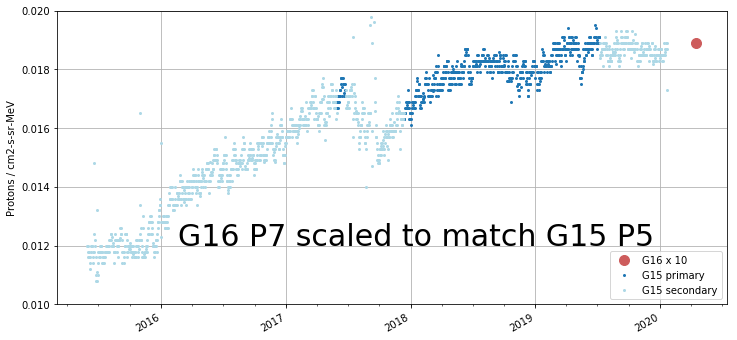

In [33]:
factor = 10

plt.figure(figsize=(12, 6))
# GOES 16
plot_cxctime([DateTime('2020:106').secs],
             [np.median(tab_all['P7_flux'] * 1000 * factor)],
             color='indianred', marker='o', ms='10', linestyle='None', label=f'G16 x {factor}')

# GOES 15
plot_cxctime(times15[okp15], t_primary['median_p5'][okp15], color='C0',
             marker='o', ms='2', linestyle='None', label='G15 primary')
plot_cxctime(times15[oks15], t_secondary['median_p5'][oks15], color='lightblue',
             marker='o', ms='2', linestyle='None', label='G15 secondary')
#plt.yscale('log')
plt.legend()
plt.ylabel('Protons / cm2-s-sr-MeV')
plt.text(DateTime('2016:050:00:00:00').plotdate, 0.012,
         'G16 P7 scaled to match G15 P5', fontsize=30, color='k')
#plt.ylim(1e-2, 2e-2)
plt.ylim(1e-2, 2e-2)
plt.grid()

## GOES-13/15 observation of the Sep-2017 flare

In [34]:
date1 = 20170909
date2 = 20170913

In [35]:
# Uncomment to retrieve the data
"""
ftp = FTP("ftp.swpc.noaa.gov")
ftp.login()

ftp.cwd("/pub/lists/pchan/")

for date in range(date1, date2):
    # primary
    primary = f"{date}_Gp_pchan_5m.txt"   
    local_filename = f"{date}_Gp_pchan_5m.txt"
    
    # retrieve the file
    lf = open(local_filename, "wb")
    ftp.retrbinary("RETR " + primary, lf.write, 8*1024)
    lf.close()
    
    # secondary
    secondary = f"{date}_Gs_pchan_5m.txt"   
    local_filename = f"{date}_Gs_pchan_5m.txt"
    
    # retrieve the file
    lf = open(local_filename, "wb")
    ftp.retrbinary("RETR " + primary, lf.write, 8*1024)
    lf.close()
""";

In [36]:
primary = []
for date in range(date1, date2):
    local_filename = f"{date}_Gp_pchan_5m.txt"
    dat = ascii.read(local_filename, data_start=2)    
    dat = Table(dat, names=NAMES)
    add_date_column(dat)
    primary.append(dat)

In [37]:
secondary = []
for date in range(date1, date2):
    local_filename = f"{date}_Gs_pchan_5m.txt"
    dat = ascii.read(local_filename, data_start=2)    
    dat = Table(dat, names=NAMES)
    add_date_column(dat)
    secondary.append(dat)

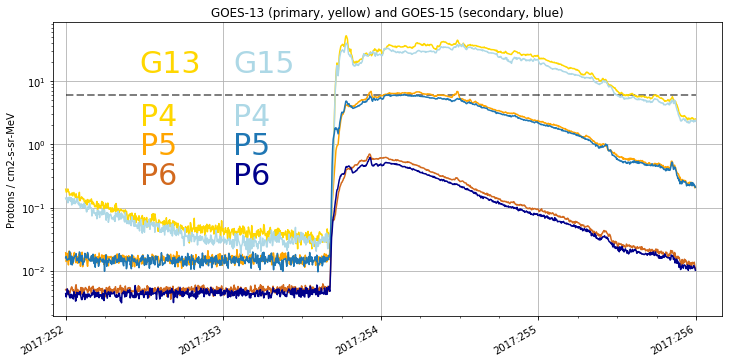

In [38]:
t1 = DateTime('2017:251:22:00:00').plotdate
t2 = DateTime('2017:256:04:00:00').plotdate

fig = plt.figure(figsize=(12, 6))
# GOES 13, primary
for dat in primary:
    plot_cxctime(DateTime(dat['date'], format='fits').secs, dat['P4'], color='gold')
    plot_cxctime(DateTime(dat['date'], format='fits').secs, dat['P5'], color='orange')
    plot_cxctime(DateTime(dat['date'], format='fits').secs, dat['P6'], color='chocolate')
# GOES 15
for dat in secondary:
    plot_cxctime(DateTime(dat['date'], format='fits').secs, dat['P4'], color='lightblue')
    plot_cxctime(DateTime(dat['date'], format='fits').secs, dat['P5'], color='C0')
    plot_cxctime(DateTime(dat['date'], format='fits').secs, dat['P6'], color='darkblue')
    
ax = fig.axes[0]
    
plt.yscale('log')
plt.ylabel('Protons / cm2-s-sr-MeV')
plt.title('GOES-13 (primary, yellow) and GOES-15 (secondary, blue)')
plt.text(0.13, 0.83, 'G13', transform=ax.transAxes, fontsize=30, color='gold')
plt.text(0.13, 0.65, 'P4', transform=ax.transAxes, fontsize=30, color='gold')
plt.text(0.13, 0.55, 'P5', transform=ax.transAxes, fontsize=30, color='orange')
plt.text(0.13, 0.45, 'P6', transform=ax.transAxes, fontsize=30, color='chocolate')
plt.text(0.27, 0.83, 'G15', transform=ax.transAxes, fontsize=30, color='lightblue')
plt.text(0.27, 0.65, 'P4', transform=ax.transAxes, fontsize=30, color='lightblue')
plt.text(0.27, 0.55, 'P5', transform=ax.transAxes, fontsize=30, color='C0')
plt.text(0.27, 0.45, 'P6', transform=ax.transAxes, fontsize=30, color='darkblue')

rate = 6
plt.hlines([rate],
           DateTime('2017:252:00:00:00').plotdate,
           DateTime('2017:256:00:00:00').plotdate,
           linestyle='--', linewidth=2, alpha=0.5)
plt.xlim(t1, t2)
plt.grid()

__Figure:__ The G16 SEISS SGPS P7 channel (40-80 MeV) in slide 10 of the following presentation
https://www.swpc.noaa.gov/sites/default/files/images/u59/06%20Rob%20Redmon%20Official.pdf
is at the level of ~2-3 protons/cm2-s-sr-MeV for 2017:254, and the GOES-13/15 flux in P5 channel (38-82 MeV) is ~6 protons/cm2-s-sr-MeV, that is only a factor 2-3 higher, on that date, but not an order of magnitude higher as in the current low proton rate period.

## HRC shield rate vs GOES proton rates

In [39]:
# Daily samples of 2shldart, HRC shield rate since Apr, 2015
dat = fetch.Msid('2shldart', '2015:100:00:00:00', '2020:031:00:00:00', stat='daily')

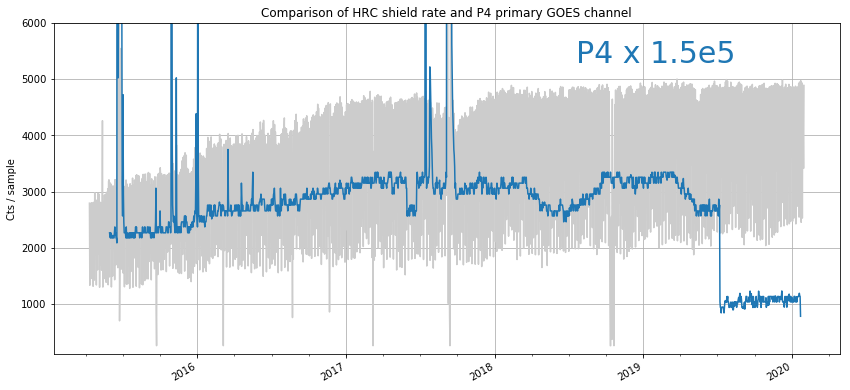

In [40]:
plt.figure(figsize=(12, 6))
plot_hrc_shield(dat.times, dat.vals, color='#cccccc', scale='linear')
plot_cxctime(DateTime(t_primary['time_mjd'], format='mjd').secs,
             t_primary['median_p4'] * 1.5e5,
             color='C0')
plt.title('Comparison of HRC shield rate and P4 primary GOES channel')
plt.ylim(100, 6000)
plt.text(DateTime('2018:200:00:00:00').plotdate, 5300, 'P4 x 1.5e5', fontsize=30, color='C0');

__Figure:__ HRC shield rate (GRAY) compared to P4 channel of the primary GOES satellite (pre-GOES-16, scaled up for the presentation purposes). Note the drop at the time of GOES-15 to GOES-14 transition in July 2019.

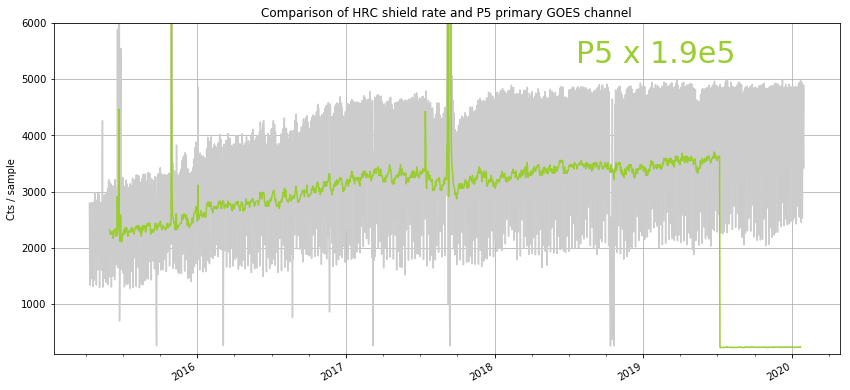

In [41]:
plt.figure(figsize=(12, 6))
plot_hrc_shield(dat.times, dat.vals, color='#cccccc', scale='linear')
plot_cxctime(DateTime(t_primary['time_mjd'], format='mjd').secs,
             t_primary['median_p5'] * 1.9e5,
             color='yellowgreen')
plt.title('Comparison of HRC shield rate and P5 primary GOES channel')
plt.ylim(100, 6000)
plt.text(DateTime('2018:200:00:00:00').plotdate, 5300, 'P5 x 1.9e5', fontsize=30, color='yellowgreen');

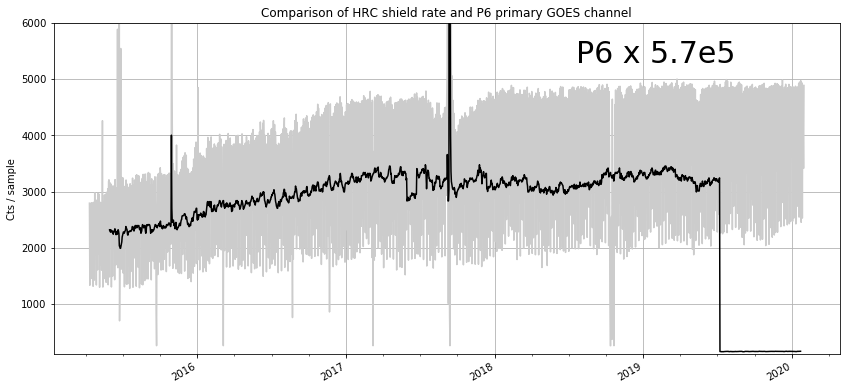

In [42]:
plt.figure(figsize=(12, 6))
plot_hrc_shield(dat.times, dat.vals, color='#cccccc', scale='linear')
plot_cxctime(DateTime(t_primary['time_mjd'], format='mjd').secs,
             t_primary['median_p6'] * 5.7e5,
             color='k')
plt.title('Comparison of HRC shield rate and P6 primary GOES channel')
plt.ylim(100, 6000)
plt.text(DateTime('2018:200:00:00:00').plotdate, 5300, 'P6 x 5.7e5', fontsize=30, color='k');